In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import tri, cm
import meshio

Definições Geométricas

In [16]:
msh = meshio.read('heat_sink.msh')

X = msh.points[:,0]
Y = msh.points[:,1]
Z = msh.points[:,2]

In [21]:
msh.cells

[<meshio CellBlock, type: triangle, num cells: 550, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 2154, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 550, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 2154, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 552, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 2154, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 552, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 2154, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 550, tags: []>,
 <meshio CellBlock, type: triangle, num cells: 2736, tags: []>,
 <meshio CellBlock, type: tetra, num cells: 123305, tags: []>]

In [20]:
msh.cell_data_dict['gmsh:physical']

{'triangle': array([2, 2, 2, ..., 2, 2, 2]),
 'tetra': array([3, 3, 3, ..., 3, 3, 3])}

In [12]:
dir(msh.cells[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data',
 'dim',
 'tags',
 'type']

In [14]:
IEN = np.array([])
IENBound = np.array([])

for cellBlock in msh.cells:
    if cellBlock.type == 'triangle':
        if IENBound.shape == (0,):
            IENBound = cellBlock.data
        else:
            IENBound = np.concatenate([IENBound, cellBlock.data])
    elif cellBlock.type == 'tetra':
        if IEN.shape == (0,):
            IEN = cellBlock.data
        else:
            IEN = np.concatenate([IEN, cellBlock.data])

In [7]:
IEN

array([[15531, 15944, 12951, 16474],
       [13621, 16207,  7312, 17094],
       [13306,  8141, 16861, 19798],
       ...,
       [10479, 10769, 23041, 17104],
       [10714, 23902,  9816, 14561],
       [10714,  9816, 23902, 10572]])

In [8]:
IENBound

array([[    0,    24,  1688],
       [  256,     0,  1688],
       [   56,     1,  1687],
       ...,
       [11520, 11602, 11692],
       [11644, 11552, 11645],
       [11590, 11586, 11660]])

In [ ]:
Npoints = len(X)
ne = IEN.shape[0]

In [ ]:
cc = np.unique(IENBound.reshape(IENBound.size))
meshio.write_points_cells('malha.vtk',
 msh.points,
 msh.cells,)

Definições do material

In [ ]:
rho = 1
cv = 1
alpha = 1

kappa = [1, 1, 1] # kx, ky, kz

Q = -6*rho*cv

In [ ]:
#form functions for 2D
def IENfunc3DTet(K, M, IEN):
    for IENelem in IEN:
        # x_list = [X[elem] for elem in IENelem]
        # y_list = [Y[elem] for elem in IENelem]
        # z_list = [Z[elem] for elem in IENelem]

        tet_matrix = np.array([[1, X[IENelem[i]], Y[IENelem[i]] , Z[IENelem[i]]] for i in range(4)])
        tet_volume = np.linalg.det(tet_matrix)/6

        # b_list = np.zeros(4, dtype = "float64") 
        # c_list = np.zeros(4, dtype = "float64") 
        # d_list = np.zeros(4, dtype = "float64")

        # for i in range(3):
        #     b_list[i] = (y_list[(i + 1)%4 - y_list[(i + 3)%4]])(z_list[(i + 2)%4] - z_list[(i + 3)%4]) - (y_list[(i + 2)%4] - y_list[(i + 3)%4])(z_list[(i + 1)%4] - z_list[(i + 3)%4])
        #     c_list[i] = (x_list[(i + 2)%4 - x_list[(i + 3)%4]])(z_list[(i + 1)%4] - z_list[(i + 3)%4]) - (x_list[(i + 1)%4] - x_list[(i + 3)%4])(z_list[(i + 2)%4] - z_list[(i + 3)%4])
        #     d_list[i] = (x_list[(i + 1)%4 - x_list[(i + 3)%4]])(y_list[(i + 2)%4] - y_list[(i + 3)%4]) - (x_list[(i + 2)%4] - x_list[(i + 3)%4])(y_list[(i + 1)%4] - y_list[(i + 3)%4])

        # b_list[3] = -sum(b_list) 
        # c_list[3] = -sum(c_list) 
        # d_list[3] = -sum(d_list) 

        melem = (tet_volume/20)*np.array(([2, 1, 1, 1],
                                          [1, 2, 1, 1],
                                          [1, 1, 2, 1],
                                          [1, 1, 1, 2]))
        
        [a_list, b_list, c_list, d_list] = np.linalg.inv(tet_matrix)
        
        kxelem = kappa[0]*tet_volume*np.array([[b_list[i]*b_list[j] for i in range(4)] for j in range(4)])
        kyelem = kappa[1]*tet_volume*np.array([[c_list[i]*c_list[j] for i in range(4)] for j in range(4)])
        kzelem = kappa[2]*tet_volume*np.array([[d_list[i]*d_list[j] for i in range(4)] for j in range(4)])

        kelem = kxelem + kyelem + kzelem

        for ilocal in range(4):
            iglobal = IENelem[ilocal]

            for jlocal in range(4):
                jglobal = IENelem[jlocal]

                K[iglobal,jglobal] += kelem[ilocal,jlocal]
                M[iglobal,jglobal] += melem[ilocal,jlocal]

In [ ]:
K  = np.zeros((Npoints, Npoints), dtype = float) 
M  = np.zeros((Npoints, Npoints), dtype = float)

IENfunc3DTet(K, M, IEN)

In [ ]:
qvec = np.full(Npoints, Q/(rho*cv))

A = K.copy()
b = M@qvec

In [ ]:
# Boundary conditions
Tcc = lambda x, y, z: x*x + y*y + z*z

In [ ]:
for i in cc:
    A[i,:] = 0.0
    A[i,i] = 1
    b[i] = Tcc(X[i], Y[i], Z[i])

In [ ]:
A_inv = np.linalg.inv(A)

In [ ]:
T_vec = A_inv@b
# T_mat = A_inv@b

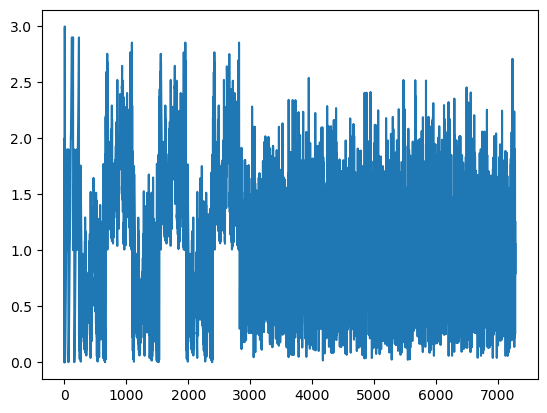

In [ ]:
plt.plot(T_vec)
plt.show()

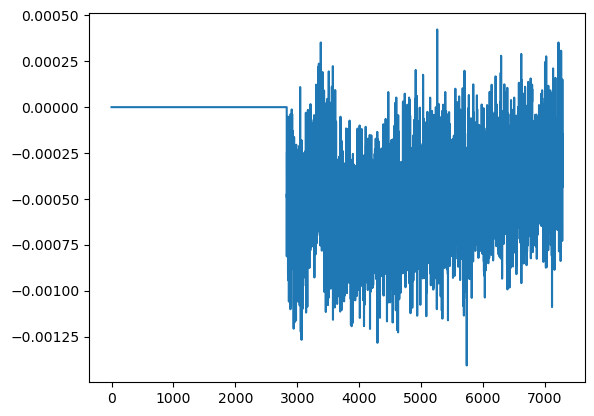

In [ ]:
plt.plot(T_vec - Tcc(X, Y, Z))
plt.show()